<a href="https://colab.research.google.com/github/swetzel1/introduction_to_ml/blob/main/project/final_project_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical Activity Monitoring


In [ ]:
#load libraries

import numpy as np
import pandas as pd
import seaborn as sns

from pandas.plotting import scatter_matrix

from imblearn.over_sampling   import SMOTE
from imblearn.under_sampling  import RandomUnderSampler

from matplotlib import pyplot as plt

from joblib import dump, load

from sklearn.preprocessing    import MinMaxScaler
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing    import StandardScaler
from sklearn                  import metrics
from sklearn.decomposition    import PCA
from sklearn.linear_model     import LogisticRegression
from sklearn.naive_bayes      import GaussianNB
from sklearn.ensemble         import RandomForestClassifier
from sklearn.svm              import SVC
from sklearn.metrics          import confusion_matrix


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [ ]:
activity_id_dict = {0: 'transient',
                    1: 'lying',
                    2: 'sitting',
                    3: 'standing',
                    4: 'walking',
                    5: 'running',
                    6: 'cycling',
                    7: 'Nordic_walking',
                    9: 'watching_TV',
                    10: 'computer_work',
                    11: 'car driving',
                    12: 'ascending_stairs',
                    13: 'descending_stairs',
                    16: 'vacuum_cleaning',
                    17: 'ironing',
                    18: 'folding_laundry',
                    19: 'house_cleaning',
                    20: 'playing_soccer',
                    24: 'rope_jumping' }



In [ ]:
#load preprocessed data
data_path = '/content/drive/My Drive/final_project/dataset/preprocessed.csv'

data = pd.DataFrame(pd.read_csv(data_path))

In [ ]:
data.head()

,heartrate,hand_temperature,hand_Acc16_1,hand_Acc16_2,hand_Acc16_3,hand_Gyro1,hand_Gyro2,hand_Gyro3,hand_Magne1,hand_Magne2,...,ankle_Acc16_1,ankle_Acc16_2,ankle_Acc16_3,ankle_Gyro1,ankle_Gyro2,ankle_Gyro3,ankle_Magne1,ankle_Magne2,ankle_Magne3,activity_id
0,0.103448,0.921875,0.545767,0.558313,0.552159,0.513015,0.441780,0.498665,0.388548,0.668452,...,0.495432,0.471040,0.486238,0.579315,0.570432,0.459166,0.598851,0.711183,0.386694,1
1,0.117241,0.664062,0.586456,0.500008,0.565538,0.512737,0.441200,0.497938,0.499793,0.669392,...,0.504800,0.470115,0.503702,0.579566,0.570602,0.459349,0.572424,0.662129,0.358806,1
2,0.206897,0.453125,0.598482,0.508803,0.556485,0.512685,0.441971,0.497963,0.461029,0.657385,...,0.498404,0.469080,0.502309,0.579900,0.571544,0.460210,0.593281,0.675533,0.376911,1
3,0.234483,0.437500,0.522582,0.539130,0.565512,0.511076,0.444953,0.501005,0.375742,0.571248,...,0.528230,0.503089,0.495722,0.570374,0.569652,0.462040,0.491398,0.600808,0.641354,1
4,0.165517,0.546875,0.600440,0.509517,0.553068,0.512867,0.443044,0.498676,0.418593,0.722963,...,0.496763,0.478225,0.477100,0.579329,0.571042,0.458785,0.583292,0.786114,0.415781,1


In [124]:
#map activity id

activity_id_mapping= {1 :0,
                      2 :1,
                      3 :2,
                      4 :3,
                      5 :4,
                      6 :5,
                      7 :6,
                     12 :7,
                     16 :8,
                     13 :9,
                     17 :10,
                     24 :11 }

data['activity_id'] = data['activity_id'].map(activity_id_mapping)

inv_activity_id_mapping = {v: k for k, v in activity_id_mapping.items()}

In [ ]:
data.head()

,heartrate,hand_temperature,hand_Acc16_1,hand_Acc16_2,hand_Acc16_3,hand_Gyro1,hand_Gyro2,hand_Gyro3,hand_Magne1,hand_Magne2,...,ankle_Acc16_1,ankle_Acc16_2,ankle_Acc16_3,ankle_Gyro1,ankle_Gyro2,ankle_Gyro3,ankle_Magne1,ankle_Magne2,ankle_Magne3,activity_id
0,0.103448,0.921875,0.545767,0.558313,0.552159,0.513015,0.441780,0.498665,0.388548,0.668452,...,0.495432,0.471040,0.486238,0.579315,0.570432,0.459166,0.598851,0.711183,0.386694,0
1,0.117241,0.664062,0.586456,0.500008,0.565538,0.512737,0.441200,0.497938,0.499793,0.669392,...,0.504800,0.470115,0.503702,0.579566,0.570602,0.459349,0.572424,0.662129,0.358806,0
2,0.206897,0.453125,0.598482,0.508803,0.556485,0.512685,0.441971,0.497963,0.461029,0.657385,...,0.498404,0.469080,0.502309,0.579900,0.571544,0.460210,0.593281,0.675533,0.376911,0
3,0.234483,0.437500,0.522582,0.539130,0.565512,0.511076,0.444953,0.501005,0.375742,0.571248,...,0.528230,0.503089,0.495722,0.570374,0.569652,0.462040,0.491398,0.600808,0.641354,0
4,0.165517,0.546875,0.600440,0.509517,0.553068,0.512867,0.443044,0.498676,0.418593,0.722963,...,0.496763,0.478225,0.477100,0.579329,0.571042,0.458785,0.583292,0.786114,0.415781,0


In [ ]:
#split x,y
col = data.columns
x_cols = col[1:]

y_df = data['activity_id']
x_df = data[x_cols]

x_np =x_df.to_numpy()
y_np =y_df.to_numpy()


In [ ]:
#PCA
k = 15 #optimal value to be found
pca = PCA(n_components=k)

x_pc = pca.fit_transform(x_np)

In [ ]:
#to tensor

x = torch.tensor(x_pc, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)

In [ ]:
#split train & val
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state = 100)

In [ ]:
y_train[:10]

tensor([9, 2, 7, 5, 0, 2, 6, 1, 4, 0])

# Neural Network

In [ ]:
#pseudo model

input_dim  = 15  # number of principal components
output_dim = 12

n_layer1 = 128

model = nn.Sequential(
            nn.Linear(input_dim, n_layer1), #layer 1
            nn.Tanh(),
            nn.Linear(n_layer1, output_dim),
            nn.LogSoftmax(dim=1))


#proper model
'''
input_dim  = 15  # input features
output_dim = 12  # no. of activities

n_layer1 = 64
n_layer2 = 128
n_layer3 = 64

model = nn.Sequential(
            nn.Linear(input_dim, n_layer1), #layer 1
            nn.Tanh(),
            nn.Linear(n_layer1, n_layer2), # layer 2
            nn.Tanh(),
            nn.Linear(n_layer2, n_layer3), # layer 3
            nn.Tanh(),
            nn.Linear(n_layer3, output_dim),
            nn.LogSoftmax(dim=1))
'''

'\ninput_dim  = 15  # input features\noutput_dim = 12  # no. of activities\n\nn_layer1 = 64\nn_layer2 = 128\nn_layer3 = 64\n\nmodel = nn.Sequential(\n            nn.Linear(input_dim, n_layer1), #layer 1\n            nn.Tanh(),\n            nn.Linear(n_layer1, n_layer2), # layer 2\n            nn.Tanh(),\n            nn.Linear(n_layer2, n_layer3), # layer 3\n            nn.Tanh(),\n            nn.Linear(n_layer3, output_dim),\n            nn.LogSoftmax(dim=1))\n'

In [ ]:
#Data Loader
batch_size   = 500
train_loader = DataLoader(list(zip(x_train, y_train)), shuffle=True, batch_size=batch_size)

In [ ]:
learning_rate = 0.01
n_epochs = 10

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()


for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:

        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.046016
Epoch: 1, Loss: 0.056502
Epoch: 2, Loss: 0.036164
Epoch: 3, Loss: 0.041765
Epoch: 4, Loss: 0.039314
Epoch: 5, Loss: 0.031510
Epoch: 6, Loss: 0.028655
Epoch: 7, Loss: 0.032341
Epoch: 8, Loss: 0.027273
Epoch: 9, Loss: 0.020719


In [ ]:
batch_size   = 20
val_loader = DataLoader(list(zip(x_val, y_val)), shuffle=True, batch_size=batch_size)


nb_classes = 12
cnf_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for x_batch, y_batch in val_loader:


        y_pred = model(x_batch)
        _, preds = torch.max(y_pred, 1)

        for t, p in zip(y_batch.view(-1), preds.view(-1)):
                cnf_matrix[t.long(), p.long()] += 1


['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'Nordic_walking',
 'ascending_stairs',
 'vacuum_cleaning',
 'descending_stairs',
 'ironing',
 'rope_jumping']

Text(0.5, 47.5815972222222, 'Predicted label')

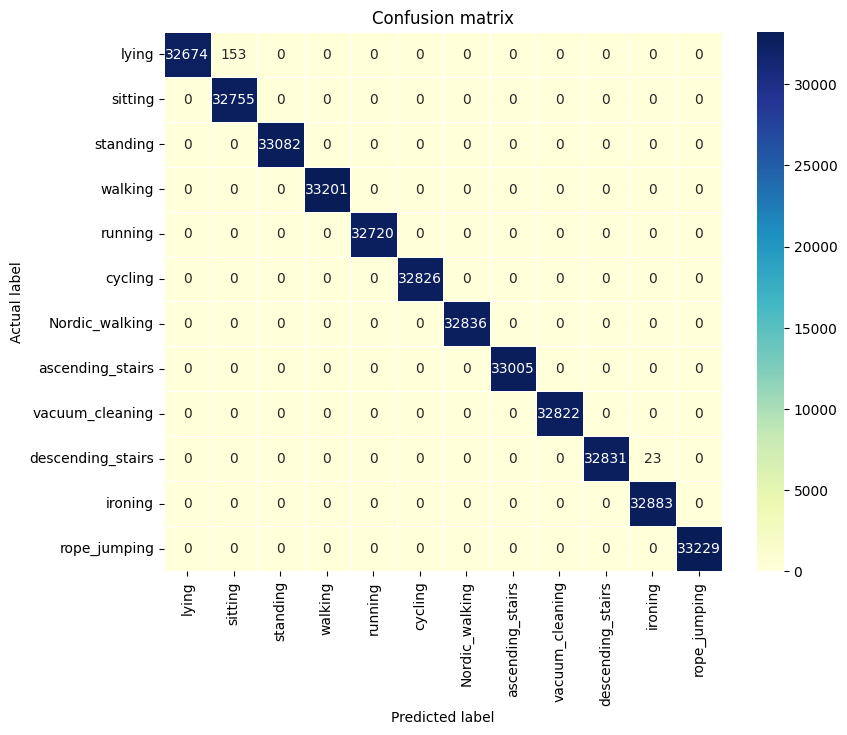

In [130]:
# create heatmap
class_names = list(range(0,12,1))
class_names = [inv_activity_id_mapping.get(x) for x in class_names]
class_names = [activity_id_dict.get(x) for x in class_names]

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',linewidths=0.5, xticklabels=class_names, yticklabels=class_names, ax=ax)

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')